# Multidimensional Motif Discovery

## Finding a Motif in Multidimensional Time Series Data with MSTUMP

This tutorial utilizes the main takeways from the [Matrix Profile VI](https://www.cs.ucr.edu/~eamonn/Motif_Discovery_ICDM.pdf) research paper. Also, the word “dimensionality” is overloaded for multi-dimensional time series since it is often used to refer to both the number of time series and to the number of data points in a subsequence. For clarity, we restrict our use of "dimensions" to refer only to the number of time series and not to the number of data points.

Previously, we had introduced a concept called [time series motifs](https://stumpy.readthedocs.io/en/latest/Tutorial_STUMPY_Basics.html), which are conserved patterns found within a 1-dimensional time series, $T$, that can be discovered by computing its [matrix profile](https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html) using STUMPY. This process of computing a matrix profile with one time series is commonly known as a "self-join" since the subsequences within time series $T$ are only being compared with itself. Since the first 1-dimensional motif discovery algorithm was introduced in 2002, a lot of effort has been made to generalize motif-finding to the multi-dimensional case but producing multi-dimensional matrix profiles are computationally expensive and so extra care must be taken to minimize the added time complexity. Also, while it may be tempting to find motifs in all avaialble dimensions (i.e., a motif must exist in all dimensions and occur simultaneously), it has been shown that this rarely produces meaningful motifs except in the most contrived situations. Instead, given a set of time series dimensions, we should filter them down to a subset of "useful" dimensions before assigning a subsequence as a motif. For example, take a look at this motion capture of a boxer throwing some punches:

In [1]:
from IPython.display import IFrame

IFrame(width="560", height="315", src="https://www.youtube.com/embed/2CQttFf2OhU")

If we strictly focus on the boxer’s right arm in both cases, the two punches are almost identical. The position of the right shoulder, right elbow, and right hand (a three dimensional time series) are virtually the indistinguishable. So, identifying this punching motif is relatively straightforward when we limit ourselves to only a subset of all of the available body movement dimensions. However, if we incorporate the full set of motion capture markers from all of the limbs (i.e., increasing the number of dimensions from three), the differences captured by the left arm and the subtle noise in the footwork actually drowns out the the similarity of the right arm motions, making the previous punching motif impossible to find. This example demonstrates how classic multidimensional motif discovery algorithms are likely to fail since they try to use all of the available dimensions. So, not only do we need an efficient algorithm for computing the multi-dimensional matrix profile but we also need to establish an informed approach to guide us in selecting the relevant subset of dimensions that are to be used to in identifying multi-dimensional motifs.

In this tutorial, we will explain precisely what a multi-dimensional matrix profile is and we'll learn how to compute it using the `mstump` function (i.e., "multi-dimensional STUMP") by exploring a simple toy dataset. Then, we'll see if we can identify a meaningful subdimensional motif (i.e., that only uses a subset of dimensions) in this multidimensional time series data.

## Getting Started

Let's import the packages that we'll need to load, analyze, and plot the data.

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import stumpy
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [20, 6]  # width, height
plt.rcParams['xtick.direction'] = 'out'

## Loading and Visualizing the Toy Data

In this example data, we have a 3-dimensional time series labeled `T1`, `T2`, and `T3`. Can you spot where the motif is? Does that motif exist in one, two, or all three dimensions?

In [3]:
df = pd.read_csv("https://zenodo.org/record/4328047/files/toy.csv?download=1")
df.head()

,T1,T2,T3
0,0.565117,0.637180,0.741822
1,0.493513,0.629415,0.739731
2,0.469350,0.539220,0.718757
3,0.444100,0.577670,0.730169
4,0.373008,0.570180,0.752406


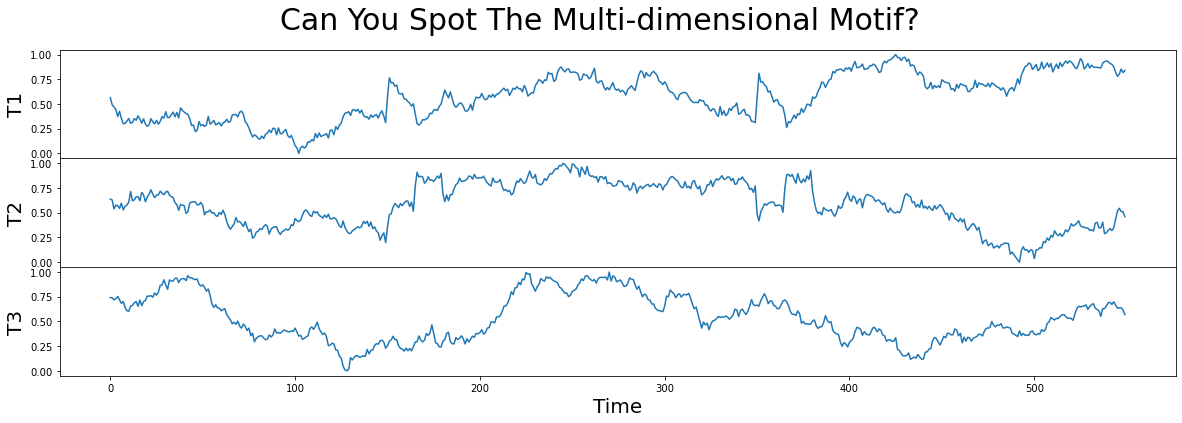

In [4]:
fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Can You Spot The Multi-dimensional Motif?', fontsize='30')

axs[0].set_ylabel('T1', fontsize='20')
axs[1].set_ylabel('T2', fontsize='20')
axs[2].set_ylabel('T3', fontsize='20')
axs[2].set_xlabel('Time', fontsize ='20')

axs[0].plot(df['T1'])
axs[1].plot(df['T2'])
axs[2].plot(df['T3'])
plt.show()

## A Quick 1-Dimensional Exploration

Before diving into a multi-dimensional matrix profile analysis, let's take a naive approach and simply run the classic 1-dimensional motif discovery algorithm, `stumpy.stump`, on each of the dimensions independently (with a window size of `m = 30`) and extract 1-dimensional motif pairs:

In [5]:
m = 30
mps = {}  # Store the 1-dimensional matrix profiles
motifs_idx = {}  # Store the index locations for each pair of 1-dimensional motifs (i.e., the index location of two smallest matrix profile values within each dimension)
for dim_name in df.columns:
    mps[dim_name] = stumpy.stump(df[dim_name], m)
    motif_distance = np.round(mps[dim_name][:, 0].min(), 1)
    print(f"The motif pair matrix profile distance in {dim_name} is {motif_distance}")
    motifs_idx[dim_name] = np.argsort(mps[dim_name][:, 0])[:2]

The motif pair matrix profile distance in T1 is 1.1
The motif pair matrix profile distance in T2 is 1.0
The motif pair matrix profile distance in T3 is 1.1


And when we plot raw times series again (below) along with their independently discovered motifs (thick red lines), we can correctly match the visually obvious motif pairs in `T1` and `T2` starting near locations `150` and `350` (dotted vertical lines). Notice that these two motifs aren't perfectly aligned in time (i.e., they aren't occuring simultaneously) but they are reasonably close to each and their motif pair distances are `1.1` and `1.0`, respectively. This is a great start!

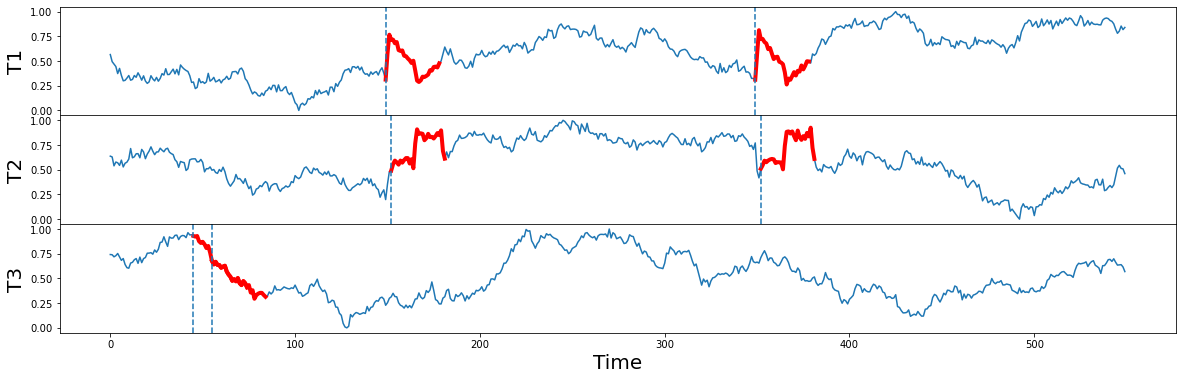

In [6]:
fig, axs = plt.subplots(len(mps), sharex=True, gridspec_kw={'hspace': 0})

for i, dim_name in enumerate(list(mps.keys())):
    axs[i].set_ylabel(dim_name, fontsize='20')
    axs[i].plot(df[dim_name])
    axs[i].set_xlabel('Time', fontsize ='20')
    for idx in motifs_idx[dim_name]:
        axs[i].plot(df[dim_name].iloc[idx:idx+m], c='red', linewidth=4)
        axs[i].axvline(x=idx, linestyle="dashed")
    
plt.show()

However, when we examine `T3`, its motif pair are overlapping each other starting near position `50` (dotted vertical lines) and they are relatively far away from the motifs discovered in `T1` and `T2`. Oh, no!

In fact, `T3` is a actually "random walk" time series that was purposely included in this set as a decoy and, unlike `T1` and `T2`, `T3` does not contain any conserved behavior whatsoever despite the fact that the distance between its motif pair is `1.1`, a red herring. This illustrates a few important points:

1. if there are additional irrelevant dimensions (i.e., `T3`), you will do about as well as random chance at discovering multi-dimensional motifs if you don't ignore/dismiss those distracting dimensions
2. if you suspect that there motifs in only a subset of the time series, how do you know which dimensions are involved, or even know how many dimensions are relevant?
3. doing motif search on all dimensions is almost always guaranteed to produce meaningless results, even if a subset of dimensions has clear and unambiguous motifs (like our example above)

A quick survey of all current multi-dimensional motif discovery algorithms in the literature (see Section II in [Matrix Profile VI](https://www.cs.ucr.edu/~eamonn/Motif_Discovery_ICDM.pdf)) reveals that they are slow, approximate, and brittle to irrelevant dimensions. In contrast, what we need is an algorithm that is fast, exact, and robust to hundreds of irrelevant dimensions and spurious data. And this is where `stumpy.mstump` can help!

## Multi-dimensional Matrix Profiles

There is no substitution for the multi-dimensional matrix profile definitions provided in the [Matrix Profile VI](https://www.cs.ucr.edu/~eamonn/Motif_Discovery_ICDM.pdf) paper (see Section III and Section IV) and so we refer the reader to this quintessential resource for a detailed walkthrough. However, to develop some basic intuition, we'll share an oversimplified description for computing a multi-dimensional matrix profile but know that the `stumpy.mstump` function provides a highly efficient, accurate, and scalable variant to the naive explanation provided here.

First and foremost, we must start by dispelling a common misconception regarding multi-dimensional matrix profiles: 

> Multi-dimensional matrix profiles are <b>not</b> 1-dimensional matrix profiles stacked one on top of each other!

So, what is a multi-dimensional matrix profile? Suppose we have a "multi-dimensional time series", $T = [T1, T2, T3, T4]$, which has $d = 4$ dimensions and length $n = 7$ (i.e., there are seven data points or "positions" within each dimension). Then, $T$ simply has shape $d\times n$ (or $4\times 7$). If we choose a window size, $m = 3$, then we can define the $i^{th}$ "multi-dimensional subsequence" as a continuous subset of the values from $T$ of length $m$ starting from position $i$ that has an overall shape of $d\times m$ (or $4\times 3$). You can think of each multi-dimensional subsequence as a rectangular slice of $T$ and $T$ can only have exactly $l = n - m + 1$ multi-dimensional subsequences. In our example, $T$ has exactly $l = 5$ multi-dimensional subsequences (i.e., we can incrementally slide a $4\times 3$-shaped rectangle across the length of $T$ only $5$ times before we reach the end of $T$) and, for the $i^{th}$ multi-dimensional subsequence, we can iterate over each of its dimensions independently and compute an aggregated "multi-dimensional distance profile" (i.e., three [1-dimensional distance profiles](https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html#Distance-Profile---Pairwise-Euclidean-Distances) stacked one on top of each other). Essentially, the $i^{th}$ multi-dimensional distance profile has shape $d\times l$ (or $3\times 5$) and gives you the pairwise distances between the $i^{th}$ multi-dimensional subsequence and all other possible multi-dimensional subsequences within $T$. For instance, consistent with our naive example, the array below may be a representative multi-dimensional distance profile for the $i^{th}$ multi-dimensional subsequence:

```
distance_profile = np.ndarray([[0.4, 0.2, 0.6, 0.5, 0.2, 0.1, 0.9],
                               [0.7, 0.0, 0.2, 0.6, 0.1, 0.2, 0.9],
                               [0.6, 0.7, 0.1, 0.5, 0.8, 0.3, 0.4],
                               [0.7, 0.4, 0.3, 0.1, 0.2, 0.1, 0.7]])
```

With this, we can now identify the $i^{th}$ set of $d$ values for the multi-dimensional matrix profile values. Notice that we are specifically focused on finding the `i^{th}` multi-dimensional matrix profile values for now, but note that the full multi-dimensional matrix profile (and its corresponding multi-dimensional matrix profile indices) has shape $l\times d$ (i.e., one set of $d$ values for each of the $l$ multi-dimensional subsequences).

In [7]:
mp, indices = stumpy.mstump(df[['T1', 'T2', 'T3']], m)

## Matrix Profile Subspace

In [8]:
from stumpy.mstump import _get_subspace

for k in range(df.shape[1]):
    motif_idx = np.argmin(mp[k, :])
    motif_mp_val = np.round(mp[k, motif_idx], 2)
    nn_idx = indices[k, motif_idx]
    mp_subspace = _get_subspace(df, m, motif_idx, nn_idx, k)
    print(f"k-Dims: {k + 1}, Motif Idx: {motif_idx}, Nearest Neighbor Idx: {nn_idx}, Motif MP Value: {motif_mp_val}, Subspace(s) {mp_subspace}")

k-Dims: 1, Motif Idx: 352, Nearest Neighbor Idx: 152, Motif MP Value: 1.0, Subspace(s) [1]
k-Dims: 2, Motif Idx: 351, Nearest Neighbor Idx: 151, Motif MP Value: 1.07, Subspace(s) [1 0]
k-Dims: 3, Motif Idx: 108, Nearest Neighbor Idx: 365, Motif MP Value: 2.87, Subspace(s) [0 1 2]


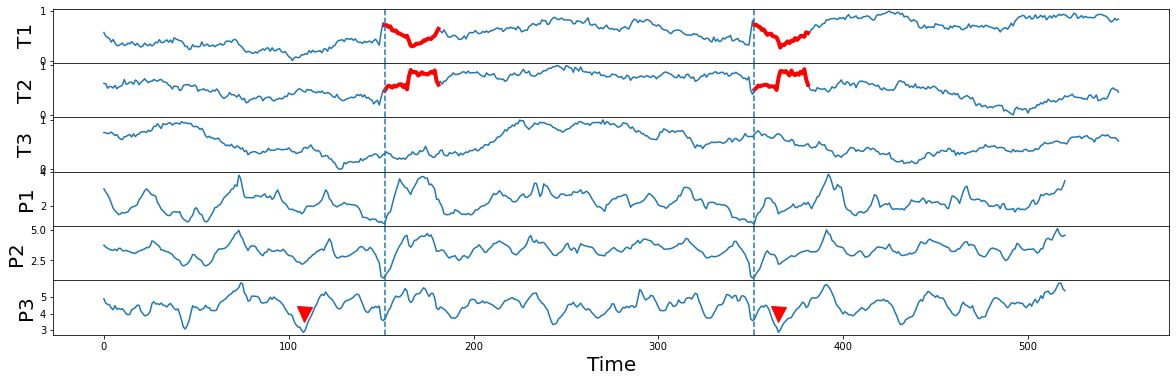

In [9]:
motif_idx = np.argpartition(mp[0, :], 2)[:2]

fig, axs = plt.subplots(6, sharex=True, gridspec_kw={'hspace': 0})

axs[0].set_ylabel('T1', fontsize='20')
axs[1].set_ylabel('T2', fontsize='20')
axs[2].set_ylabel('T3', fontsize='20')

axs[0].plot(df['T1'])
axs[1].plot(df['T2'])
axs[2].plot(df['T3'])

for idx in motif_idx:
    axs[0].plot(df['T1'].iloc[idx:idx+m], c='red', linewidth=4)
    axs[1].plot(df['T2'].iloc[idx:idx+m], c='red', linewidth=4)
    for p in range(6):
        axs[p].axvline(x=idx, linestyle="dashed")

axs[3].set_ylabel('P1', fontsize='20')
axs[4].set_ylabel('P2', fontsize='20')
axs[5].set_ylabel('P3', fontsize='20')

axs[3].plot(mp[0, :])
axs[4].plot(mp[1, :])
axs[5].plot(mp[2, :])

motif_idx = np.argpartition(mp[2, :], 2)[:2]
for idx in motif_idx:
    plt.plot(idx, 4, marker="v", markersize=15, color='red')

axs[5].set_xlabel('Time', fontsize ='20')
plt.show()

## TO DO

1. Matrix Profile Subspace
2. MDL
3. Guided Search
4. Include, Discords
5. Explicitly state the a multi-dimensional matrix profile is NOT a stack of 1D matrix profiles

## Scaling to Multiple Distributed Servers with MSTUMPED

## Summary

And that's it! You've just learned the basics of how to analyze multi-dimensional time series data using `stumpy.mstump` (or `stumpy.mstumped`)!

## Resources

[Matrix Profile VI](https://www.cs.ucr.edu/~eamonn/Motif_Discovery_ICDM.pdf)

[STUMPY Documentation](https://stumpy.readthedocs.io/en/latest/)

[STUMPY Matrix Profile Github Code Repository](https://github.com/TDAmeritrade/stumpy)